### ES 1

In [63]:
# import to avoid warning about unused imports
import warnings
warnings.filterwarnings("ignore")

The CSV file disease_screening.csv contains 20 biomarkers and the categorical outcome disease. The disease variable takes values 0, 1, 2, 3, and 4, where 0 corresponds to a healthy patient and 1 to 4 are associated with four different kinds of diseases.

Split the dataset into training and testing using the `train_test_split` function with parameters `test_size=0.3, random_state=42.

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv("disease_screening (3).csv")
df.head()
X = pd.DataFrame(df.drop(columns=['disease']))
y = df['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [65]:
#Apply forward step-wise feature selection on a logistic regression model using BIC as the criterion. List the selected variables.
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

def compute_bic(X_sub, y_sub):
    X_const = sm.add_constant(X_sub)
    model = sm.MNLogit(y_sub, X_const)
    result = model.fit(disp=False)
    return result.bic


selected = [] #features selezionate 
remaining = list(X_train.columns) #feature che rimangono
best_bic = np.inf #miglior bic fino ad ora

while remaining: #finche ci sono delle feature 
    bic_list = []
    for feat in remaining:
        bic = compute_bic(X_train[selected + [feat]], y_train)
        bic_list.append((bic, feat))
    bic_list.sort() #ordino i bic
    bic_candidate, feature_candidate = bic_list[0] #prendo il miglior bic e la feature associata

    
    if bic_candidate < best_bic: #se il bic candidato è migliore del miglior bic
        best_bic = bic_candidate #aggiorno il miglior bic
        selected.append(feature_candidate) #aggiungo la feature selezionata
        remaining.remove(feature_candidate) #rimuovo la feature selezionata dalle rimanenti
    else:
        break
    
print("Selected features:", selected)


Selected features: ['bio_15', 'bio_17', 'bio_19', 'bio_3', 'bio_14', 'bio_5']


In [66]:
def compute_bic(X_sub, y_sub):
    X_const = sm.add_constant(X_sub)
    model = sm.MNLogit(y_sub, X_const)
    result = model.fit(disp=False, max_iter=100)
    return result.bic


selected = list(X_train.columns)  # Parti con TUTTE le features
best_bic = compute_bic(X_train[selected], y_train)  # BIC iniziale con tutte le features

while len(selected) > 1:  # Finché hai più di 1 feature
    bic_list = []
    for feat in selected:
        # Testa rimuovendo questa feature
        remaining_features = [f for f in selected if f != feat]
        bic = compute_bic(X_train[remaining_features], y_train)
        bic_list.append((bic, feat))
    
    bic_list.sort()  # Ordino i BIC
    bic_candidate, feature_candidate = bic_list[0]  # Prendo il miglior BIC e la feature da rimuovere
    
    if bic_candidate < best_bic:  # Se rimuovere questa feature migliora il BIC
        best_bic = bic_candidate  # Aggiorno il miglior BIC
        selected.remove(feature_candidate)  # Rimuovo la feature dalle selezionate
    else:
        break  # Stop se rimuovere qualsiasi feature peggiora il modello
    
print("Selected features:", selected)


Selected features: ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8', 'bio_11', 'bio_12', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_19', 'bio_20']


Fit a lasso-penalised logistic regression (solver='saga') with nested 5-fold cross-validation to tune the shrinkage parameter. Report the value of the optimal C. 
Use as candidate values: Cs = np.logspace(-3, 3, 15)

In [67]:
# finding the best value of C for Lasso regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score 


Cs = np.logspace(-3, 3, 15)
from sklearn.model_selection import GridSearchCV

lasso_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='saga', max_iter=1000),
    param_grid={'C': Cs}, cv=10, scoring='accuracy'
)
lasso_search.fit(X_train, y_train)
lasso_best = lasso_search.best_estimator_
lasso_cv_acc = lasso_search.best_score_
lasso_test_acc = lasso_best.score(X_test, y_test)

lasso_best.C

np.float64(0.3727593720314938)

In [68]:
# cross validation with accuracy
lasso_scores = cross_val_score(lasso_search, X_train, y_train, cv=5, scoring='accuracy')

lasso_cv_acc = lasso_scores.mean()
lasso_cv_acc_std = lasso_scores.std()


In [69]:
lasso_scores.mean()

np.float64(0.7666666666666666)

In [70]:
# using the best features from the forward step-wise selection
print("Selected features from forward selection:", selected)

model = LogisticRegression()

scores = cross_val_score(model, X_train[selected], y_train, cv=5, scoring='accuracy')

scores.mean() 

Selected features from forward selection: ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8', 'bio_11', 'bio_12', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_19', 'bio_20']


np.float64(0.763888888888889)

For all the following questions, consider the multiclass classification problem where the goal is to predict exactly the feature disease. 
Fit a gradient boosting classifier algorithm. Use 5-fold cross-validation to select the learning rate parameter among the values [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]. What is the value of the learning rate?

In [71]:
# gradient boosting classifier algorithm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

learning_rated = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
search = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid={'learning_rate': learning_rated},
    cv=5,
    scoring='accuracy'
)
search.fit(X_train, y_train)
gb_best = search.best_estimator_
best_param = search.best_params_['learning_rate']
best_param

0.1

Compute the 5 × 5 confusion matrix for the classification on the test set.

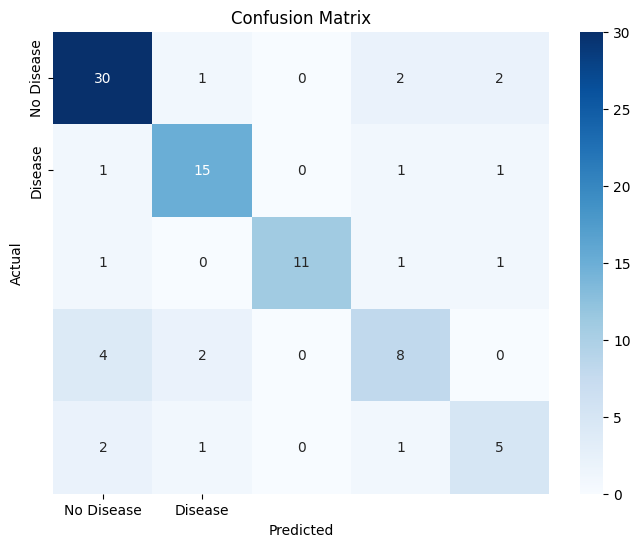

In [72]:
# computing the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, search.predict(X_test))
conf_matrix
# heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Fit a random forest classifier and report the OOB accuracy and the accuracy on the test set.

In [78]:
# importing random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model = RandomForestClassifier(oob_score=True)
model.fit(X_train, y_train)

model.predict(X_test)

model.oob_score_, model.score(X_test, y_test)

(0.8305555555555556, 0.7888888888888889)